数据加载

In [ ]:
import numpy as np
import os
def load_data(root):
    path_list = [path for path in os.listdir(root)]
    data = []
    label = []
    for data_path in path_list:
        data_org = np.load(os.path.join(root, data_path))
        if data_path[1] == '3':  # 1: hard fall 2: soft fall 3: non-fall
            lb = 0
        else:
            lb = 1
        data.append(data_org)
        label.append(lb)
    return np.array(data),np.array(label)

if __name__=='__main__':
    os.chdir('/tmp/FYP/12_DTweighted')

    ROOT = '/tmp/FYP/12_DTweighted/'
    train_path = ROOT + 'train/'
    test_path = ROOT + 'test/'
    trainX,trainy = load_data(train_path)
    testX,testy = load_data(test_path)

    print(load_data(train_path))
    print(load_data(test_path))
    
    print("data loaded")

分析数据维度：二维数组（128,64），8192个数据点


数据文件命名:


1.data_path[1] 代表hard, soft, non-fall


2.data_path[2] 和 data_path[3]两位代表28个属性


3.数据集里面Hard:1-9, soft:10-14, non-fall:15-28

In [2]:
import numpy as np
import os
data_example = np.load('train_new/4101010001210420_1_031_DTweighted01.npy')

out_file_path = 'data.txt'
with open(out_file_path,'w') as f:
    f.write(np.array2string(data_example, threshold=np.inf))

print("Printed!")
print("Array Shape:",data_example.shape)
print("Data Shape:",data_example.dtype)

with open(out_file_path,'r') as file:
    content = file.read()
    print(content)


Printed!
Array Shape: (128, 64)
Data Shape: float64
[[-5.21894130e+25  9.75868917e+25 -4.37929301e+25 -1.29058356e+26
  -1.29104261e+27 -4.31474509e+26  7.10984510e+25 -6.87176044e+26
  -1.29321431e+27 -1.15224717e+27  7.71847928e+26 -8.83235493e+26
  -8.52936051e+26 -3.20578232e+27 -2.53800506e+26 -4.76391209e+27
  -5.17201657e+26 -5.97006293e+27 -1.44463905e+27 -1.04721121e+28
  -1.66704038e+26 -8.81987297e+27 -1.89402447e+27 -1.79987993e+28
  -3.57281852e+26 -1.18376222e+28 -1.99977758e+27 -2.54043766e+28
  -1.21744091e+27 -1.57613397e+28 -3.72359955e+27 -3.11226784e+28
  -9.34431258e+26 -1.53068568e+28 -3.13835667e+27 -3.19099276e+28
  -1.50330501e+27 -1.61334598e+28 -3.13607606e+27 -3.19493711e+28
  -2.63573130e+27 -1.77415342e+28 -3.64514127e+27 -2.92483664e+28
  -9.27008657e+26 -1.53104340e+28 -4.64789919e+27 -2.61475921e+28
   3.11533484e+26 -1.25882671e+28 -4.90012403e+27 -2.36812276e+28
  -1.13194807e+27 -1.26718117e+28 -6.05078234e+27 -2.27555375e+28
   1.53932412e+27 -6.236

取一个示例数据，做出Doppler-Time map

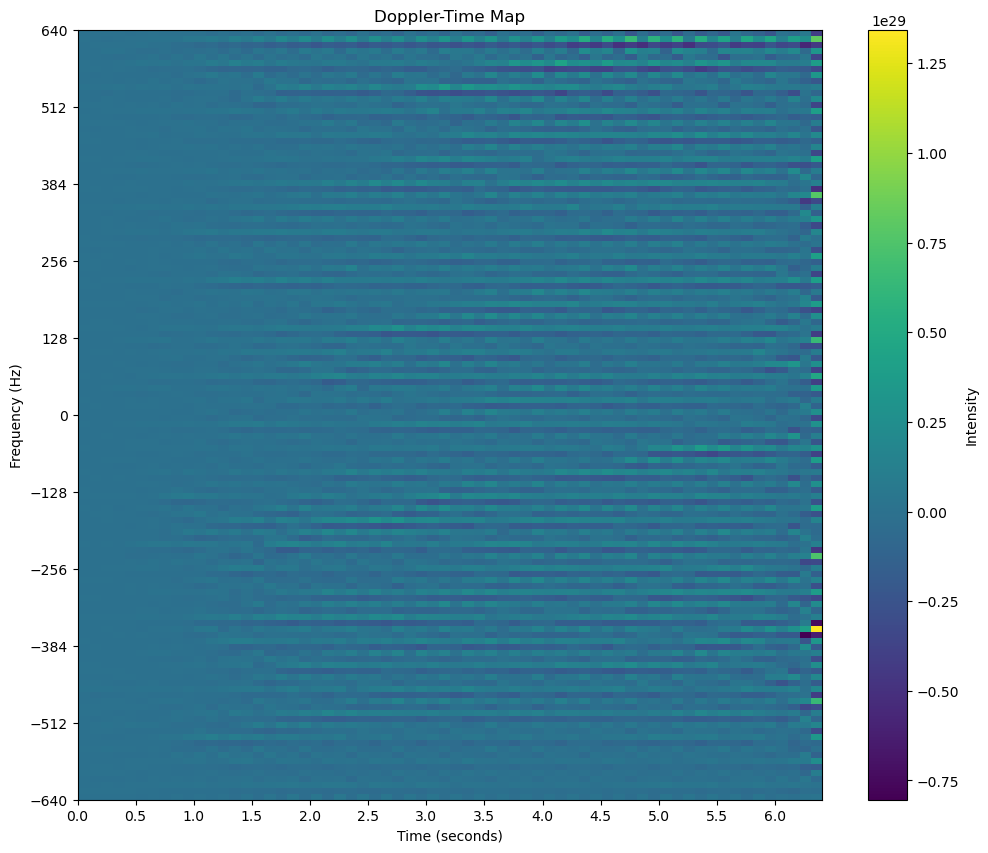

In [5]:
import matplotlib.pyplot as plt

# 加载.npy文件
data_train_example = np.load('train_new/4101010001210420_1_031_DTweighted02.npy')  # 使用实际路径替换

# 设置时间轴，假设每十个数据点代表1秒，总共有64个数据点
time_ticks = np.linspace(0, 6.4, 64)  # 64个数据点，最大值为6.4秒

# 设置频率轴，从-640 Hz到+640 Hz，总共128个数据点
frequency_ticks = np.linspace(-640, 640, 128)

# 创建图像并设置大小
plt.figure(figsize=(12, 10))

# 绘制Doppler-time map
plt.imshow(data_train_example, aspect='auto', cmap='viridis', interpolation='none',
           extent=[time_ticks.min(), time_ticks.max(), frequency_ticks.min(), frequency_ticks.max()])

# 设置颜色条和标题
plt.colorbar(label='Intensity')
plt.title('Doppler-Time Map')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')

# 调整刻度密度
plt.xticks(np.arange(0, time_ticks.max(), 0.5))
plt.yticks(np.arange(frequency_ticks.min(), frequency_ticks.max()+1, 128))

# 保存图像，使用较高的dpi值
plt.savefig('doppler_time_map_high_res.png', dpi=300)  # 使用高分辨率保存

plt.show()

实验目的：对（128,64）数据进行数据增强

实验方法：Stable Diffusion

之后跑分类模型

Stable Diffusion架构

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim

# 检查CUDA是否可用，选择正确的设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 定义U-Net模型
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.time_embedding = nn.Linear(1, 16)
        self.down1 = nn.Sequential(nn.Conv2d(1 + 16, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64))
        self.down2 = nn.Sequential(nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.ReLU(), nn.BatchNorm2d(128))
        self.down3 = nn.Sequential(nn.Conv2d(128, 256, 3, stride=2, padding=1), nn.ReLU(), nn.BatchNorm2d(256))
        self.up2 = nn.Sequential(nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), nn.ReLU(), nn.BatchNorm2d(128))
        self.up3 = nn.Sequential(nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), nn.ReLU(), nn.BatchNorm2d(64))
        self.final = nn.Conv2d(64, 1, 3, padding=1)

    def forward(self, x, t):
        t_emb = self.time_embedding(t).unsqueeze(-1).unsqueeze(-1)
        t_emb = t_emb.expand(-1, -1, x.shape[2], x.shape[3])
        x = torch.cat([x, t_emb], dim=1)
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x = self.up2(x3)
        x = self.up3(x + x2)
        x = self.final(x + x1)
        return x

# 自定义数据集
class ImageDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.files = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith('.npy')]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = np.load(self.files[idx])
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # 通道  # 归一化并添加通道维度
        return img, os.path.basename(self.files[idx])

# 扩散和逆扩散步骤
def diffusion_step(x, beta=0.1):
    noise = torch.randn_like(x).to(device)
    return np.sqrt(1 - beta) * x + np.sqrt(beta) * noise

def reverse_diffusion_step(x_t, t, model):
    pred_noise = model(x_t, t)
    beta = 0.1
    return (x_t - np.sqrt(beta) * pred_noise) / np.sqrt(1 - beta)

# 训练函数
def train(model, data_loader, epochs=10):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()
    for epoch in range(epochs):
        for batch, _ in data_loader:
            x = batch.to(device)
            t = torch.rand(x.size(0), 1).to(device)
            x_t = diffusion_step(x, beta=0.1)
            pred_noise = model(x_t, t)
            true_noise = x - diffusion_step(x, beta=0.1)
            loss = loss_fn(pred_noise, true_noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# 采样函数和保存
def generate_and_save_samples(model, data_loader, output_dir='train_new', num_variants=3):
    model.eval()
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    timesteps = 1000
    with torch.no_grad():
        for batch, filenames in data_loader:
            for x, filename in zip(batch, filenames):
                x = x.unsqueeze(0).to(device)
                for i in range(num_variants):
                    x_t = torch.randn_like(x)
                    for t in reversed(range(timesteps)):
                        time_step = torch.full((1, 1), fill_value=t/timesteps, device=device)
                        x_t = reverse_diffusion_step(x_t, time_step, model)
                    sample_np = x_t.cpu().numpy().squeeze()
                    variant_filename = os.path.basename(filename).replace('.npy', f'-{i+1:02}.npy')
                    np.save(os.path.join(output_dir, variant_filename), sample_np.astype(np.float64))


# 实例化模型和数据加载
model = UNet().to(device)
dataset = ImageDataset('train')
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

print("data loaded!")
# 训练模型
train(model, dataloader)

# 生成样本并保存
generate_and_save_samples(model, dataloader)

print("Task finished!")


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LKCNN(nn.Module):
    def __init__(self):
        super(LKCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(7, 1), stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=(4, 1), stride=(4, 1))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 9), stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=(1, 4), stride=(1, 4))

        self.fc1 = nn.Linear(64 * 30 * 14, 1024)  # 此处的乘数需要根据实际尺寸计算得到

        self.fc2 = nn.Linear(1024, 3)

    def forward(self, x):

        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # 动态计算展平后的尺寸
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = LKCNN()
print(model)

# 假设有一个随机数据批次和标签
inputs = torch.randn(1, 1, 128, 64)  # batch_size=1, channels=1, height=128, width=64
labels = torch.randint(0, 3, (1,))  # batch_size=1, classes=10

# 前向传播
outputs = model(inputs)
loss_function = nn.CrossEntropyLoss()
loss = loss_function(outputs, labels)

print(loss)
